In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import tensorflow as tf

In [0]:
np.random.seed(101)
tf.set_random_seed(101)

## Dataset
We'll be using the CIFAR-10 dataset, which is very famous dataset for image recognition! 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 


In [3]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(y_train.shape)
print('')
print(X_test.shape)
print(y_test.shape)

Using TensorFlow backend.


(50000, 32, 32, 3)
(50000, 1)

(10000, 32, 32, 3)
(10000, 1)


In [4]:
# Dataset is already not normalized
display(X_train[2].max())
display(X_train[2].min())

255

20

[6]


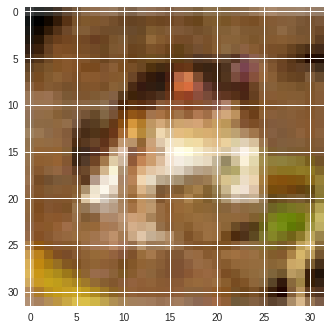

In [5]:
# Sample
display(plt.imshow(X_train[0]))
print(y_train[0])

## Feature Engineering 

In [6]:
# Normalize X
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert to tensor
X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
# One hot encoding y
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print(y_train_cat.shape)
print(y_test_cat.shape)

(50000, 10)
(10000, 10)


## Model - Keras

In [8]:
# Equivalent Keras Model
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Activation, Dropout
import keras.backend as K

K.clear_session()

model = Sequential()

# Feature Extraction layers
model.add(Conv2D(32, (4, 4), input_shape=(32, 32, 3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(64, (4, 4), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))

model.add(Activation('relu'))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        1568      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
__________

## Model - Tensorflow

In [0]:
def init_weights(shape):
    """Init weight"""
    # Random normal distribution
    init_random_dist = tf.truncated_normal(
        shape, 
        stddev=0.1)
    return tf.Variable(init_random_dist)


def init_bias(shape):
    """Init bias"""
    # Constant 0.1
    init_bias_vals = tf.constant(
        0.1,
        shape=shape)
    return tf.Variable(init_bias_vals)

In [0]:
def conv2d(x, W):
    # x tensor: [batch, H, W, C]
    # W tensor: [filter H, filter W, Cin, Cout]
    return tf.nn.conv2d(
        x, W,
        strides=[1, 1, 1, 1], 
        padding='SAME')


def conv_layer(x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(x, W) + b)


def max_pool_2by2_layer(x):
    # tensor x: [batch, H, W, C]
    return tf.nn.max_pool(
        x, 
        ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1],
        padding='SAME')


def dense_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [11]:
# Placeholder
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

###################################### Stack layers ###############################################
input_img = tf.reshape(x, [-1,32,32,3])

# Feature Extraction layers
convo_1 = conv_layer(
    input_img,
    shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2_layer(convo_1)

convo_2 = conv_layer(
    convo_1_pooling,
    shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2_layer(convo_2)

# Flatten layer
convo_2_flat = tf.reshape(convo_2_pooling,[-1, 8*8*64])

# Fully connected layers
dense_layer_one = tf.nn.relu(
    dense_layer(convo_2_flat, 1024))

hold_prob = tf.placeholder(tf.float32)
dense_one_dropout = tf.nn.dropout(
    dense_layer_one,
    keep_prob=hold_prob)

y_pred = dense_layer(dense_one_dropout, 10)
###################################################################################################

# Loss function
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=y_true,
        logits=y_pred))

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
# Init Variables
init = tf.global_variables_initializer()

# Steps
steps = 5001

# Batch size
batch_size = 100

with tf.Session() as sess:
    # Init Variables
    sess.run(init)
    
    for i in range(steps):
        rand_ind = np.random.randint(
            len(X_train),
            size=batch_size)
        
        batch_x = X_train[rand_ind]
        batch_y = y_train_cat[rand_ind]
        
        sess.run(
            train,
            feed_dict={
                x:batch_x,
                y_true:batch_y,
                hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 500 STEPS
        if i%500 == 0:
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(
                acc,
                feed_dict={
                    x:X_test,
                    y_true:y_test_cat,
                    hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1183


Currently on step 500
Accuracy is:
0.5482


Currently on step 1000
Accuracy is:
0.6171


Currently on step 1500
Accuracy is:
0.6576


Currently on step 2000
Accuracy is:
0.682


Currently on step 2500
Accuracy is:
0.6865


Currently on step 3000
Accuracy is:
0.6903


Currently on step 3500
Accuracy is:
0.7029


Currently on step 4000
Accuracy is:
0.711


Currently on step 4500
Accuracy is:
0.7116


Currently on step 5000
Accuracy is:
0.7106


